# Crypto Currencies - Time Series Forecasting
# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
# Implement Hyperparameter tunning on the available models.

# Start on creating the classes for the Hybrid Models
# Exponential Smoothing (ES)
# Multi-Layer Perceptron (MLP) 
# Recurrent Neural Network (RNN) 
# Temporal Fusion Transformer (TFT - Google)
# DeepAR
# N-BEATS


In [2]:
#!pip install cryptocmd
#!pip install arch
#!pip install prophet
#!pip install torch
#!pip install tensorflow
#!pip install keras-tuner
#!pip install lightgbm
#!pip install xgboost
#!pip install prettytable
#!pip install bokeh
#!pip install pmdarima
#!pip uninstall statsmodels --y
#%pip install torch
#%pip install pytorch-forecasting

In [10]:
# Standard library imports
import os
import time
import warnings
import sys
import requests
import pickle
import logging
import joblib


# Third party imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Data Preprocessing and Analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from cryptocmd import CmcScraper

# Deep Learning and Machine Learning Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
from keras_tuner.tuners import RandomSearch
from kerastuner import HyperModel
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


# Metrics and Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score
from prettytable import PrettyTable

# Plotting and Visualization
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme

# Time Series Analysis and Forecasting
import pmdarima as pm
from arch import arch_model

# Miscellaneous
from joblib import dump, load
from math import pi

# Warnings and Logging
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)

# Block 1. - CryptoDate

In [11]:
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        logging.info("Initializing CryptoData class")
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        logging.info(f"Fetching {self.crypto_symbol} data")
        try:
            scraper = CmcScraper(self.crypto_symbol)
            df = scraper.get_dataframe()
            if not {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}.issubset(df.columns):
                raise ValueError("Some expected columns are missing in the data.")
            logging.info(f"Data fetched successfully for {self.crypto_symbol}")
            return df
        except Exception as e:
            logging.error(f'An error occurred while fetching data: {e}')
            raise  # Propagate the exception

    def get_cryptocmd_data(self) -> pd.DataFrame:
        logging.info(f"Getting {self.crypto_symbol} data")
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        logging.info(f"Data obtained successfully for {self.crypto_symbol}")
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        logging.info(f"Formatting display data for {self.crypto_symbol}")
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)

        # Check and apply volume formatting only if they are of numeric type
        volume_like_columns = ['Volume', 'Market Cap']
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(display_df[column]):
                display_df[column] = display_df[column].apply(self._format_volume_value)

        logging.info(f"Display data formatted successfully for {self.crypto_symbol}")
        return display_df


In [12]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
data

2023-07-22 19:40:13,134 [INFO] - Initializing CryptoData class
2023-07-22 19:40:13,136 [INFO] - Getting BTC data
2023-07-22 19:40:13,138 [INFO] - Fetching BTC data
2023-07-22 19:40:13,401 [INFO] - Data fetched successfully for BTC
2023-07-22 19:40:13,414 [INFO] - Data obtained successfully for BTC


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-07-20,29915.250,30195.530,29638.100,29792.020,14655207120.530,579003905761.260
2023-07-19,29862.050,30184.180,29794.270,29913.920,12128602811.700,581348679162.130
2023-07-18,30147.070,30233.660,29556.430,29856.560,13138897269.160,580205937049.990
2023-07-17,30249.630,30336.400,29685.780,30145.890,13240156074.070,585797549895.290
2023-07-16,30297.470,30437.560,30089.670,30249.130,8516564469.720,587778068681.360
...,...,...,...,...,...,...
2013-05-01,139.000,139.890,107.720,116.990,0.000,1298954593.750
2013-04-30,144.000,146.930,134.050,139.000,0.000,1542813125.000
2013-04-29,134.440,147.490,134.000,144.540,0.000,1603768864.500


# Block 2. - Crypto Analytics

In [13]:
# Block 2 - Crypto analytics
class CryptoAnalytics:
    """
    This class is responsible for performing analytics on cryptocurrency data.

    Input:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.

    Methods:
        get_all_time_records: Returns the all-time high and low closing prices.
        get_yearly_analysis: Returns yearly high, low, average, and variation.
        get_monthly_analysis: Returns monthly high, low, average, and variation.
        get_weekly_analysis: Returns weekly high, low, average, and variation.
    """
    def __init__(self, crypto_data: CryptoData):
        logger.info("Initializing CryptoAnalytics class")
        self.df = crypto_data.get_cryptocmd_data()

    def format_and_round(self, number):
        return f'{number:,.2f}'

    def apply_custom_formatting(self, data):
        logger.info("Applying custom formatting")
        ordered_columns = [
            'Open_first', 'Close_last', 'variation_$_abs',
            'variation_%_rel', 'Close_min', 'Close_mean', 'Close_max'
        ]
        data = data[ordered_columns]
        return data

    def get_all_time_records(self):
        logger.info("Getting all time records")
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date

    def get_yearly_analysis(self):
        logger.info("Getting yearly analysis")
        yearly_data = self.df.resample('Y').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        yearly_data.columns = yearly_data.columns.map('_'.join).str.strip('_')
        yearly_data = self.calculate_variation(yearly_data)
        return self.apply_custom_formatting(yearly_data)

    def get_monthly_analysis(self):
        logger.info("Getting monthly analysis")
        monthly_data = self.df.resample('M').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        monthly_data.columns = monthly_data.columns.map('_'.join).str.strip('_')
        monthly_data = self.calculate_variation(monthly_data)
        return self.apply_custom_formatting(monthly_data)

    def get_weekly_analysis(self):
        logger.info("Getting weekly analysis")
        weekly_data = self.df.resample('W').agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        weekly_data.columns = weekly_data.columns.map('_'.join).str.strip('_')
        weekly_data = self.calculate_variation(weekly_data)
        return self.apply_custom_formatting(weekly_data)

    def calculate_variation(self, data):
        logger.info("Calculating variation")
        data['variation_$_abs'] = data['Close_last'] - data['Open_first']
        data['variation_%_rel'] = ((data['Close_last'] - data['Open_first']) / data['Open_first']) * 100
        return data

    def display_all_analyses(self):
        logger.info("Displaying all analyses")
        all_time_high, all_time_low, all_time_high_date, all_time_low_date = self.get_all_time_records()
        print(f"All Time High: {self.format_and_round(all_time_high)} (Date: {all_time_high_date})")
        print(f"All Time Low: {self.format_and_round(all_time_low)} (Date: {all_time_low_date})")

        print("\nYearly Analysis:")
        display(self.get_yearly_analysis())

        print("\nMonthly Analysis:")
        display(self.get_monthly_analysis())

        print("\nWeekly Analysis:")
        display(self.get_weekly_analysis())

In [14]:
# Create an instance of CryptoAnalytics
analytics = CryptoAnalytics(crypto)
# Display all analyses
analytics.display_all_analyses()

2023-07-22 19:40:14,291 [INFO] - Initializing CryptoAnalytics class
2023-07-22 19:40:14,292 [INFO] - Getting BTC data
2023-07-22 19:40:14,293 [INFO] - Fetching BTC data
2023-07-22 19:40:14,574 [INFO] - Data fetched successfully for BTC
2023-07-22 19:40:14,588 [INFO] - Data obtained successfully for BTC
2023-07-22 19:40:14,593 [INFO] - Displaying all analyses
2023-07-22 19:40:14,595 [INFO] - Getting all time records
2023-07-22 19:40:14,597 [INFO] - Getting yearly analysis
2023-07-22 19:40:14,608 [INFO] - Calculating variation
2023-07-22 19:40:14,611 [INFO] - Applying custom formatting


All Time High: 67,566.83 (Date: 2021-11-08)
All Time Low: 68.43 (Date: 2013-07-05)

Yearly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-12-31,139.410,754.010,614.600,440.858,68.430,256.964,1151.170
2014-12-31,754.970,320.190,-434.780,-57.589,310.740,527.237,953.290
2015-12-31,320.430,430.570,110.140,34.373,178.100,272.453,465.320
2016-12-31,430.720,963.740,533.020,123.751,364.330,568.492,975.920
2017-12-31,963.660,14156.400,13192.740,1369.024,777.760,4006.034,19497.400
2018-12-31,14112.200,3742.700,-10369.500,-73.479,3236.760,7572.299,17527.000
2019-12-31,3746.710,7193.600,3446.890,91.998,3399.470,7395.247,13016.230
2020-12-31,7194.890,29001.720,21806.830,303.088,4970.790,11116.378,29001.720
2021-12-31,28994.010,46306.450,17312.440,59.710,29374.150,47436.932,67566.830


2023-07-22 19:40:14,626 [INFO] - Getting monthly analysis
2023-07-22 19:40:14,646 [INFO] - Calculating variation
2023-07-22 19:40:14,648 [INFO] - Applying custom formatting



Monthly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-30,139.410,139.000,-0.410,-0.294,127.950,137.048,144.540
2013-05-31,139.000,129.000,-10.000,-7.194,97.750,119.993,133.480
2013-06-30,128.820,96.610,-32.210,-25.004,94.650,107.761,129.300
2013-07-31,97.510,106.090,8.580,8.799,68.430,90.512,107.990
2013-08-31,106.210,135.350,29.140,27.436,102.800,113.905,135.350
...,...,...,...,...,...,...,...
2023-03-31,23150.930,28478.480,5327.550,23.012,20187.240,25116.901,28478.480
2023-04-30,28473.330,29268.810,795.480,2.794,27276.910,28857.574,30485.700
2023-05-31,29227.100,27219.660,-2007.440,-6.868,26334.820,27499.307,29534.380


2023-07-22 19:40:14,665 [INFO] - Getting weekly analysis
2023-07-22 19:40:14,685 [INFO] - Calculating variation
2023-07-22 19:40:14,690 [INFO] - Applying custom formatting



Weekly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-28,139.410,127.950,-11.460,-8.220,127.950,132.325,136.700
2013-05-05,134.440,115.910,-18.530,-13.783,97.750,118.843,144.540
2013-05-12,115.980,115.000,-0.980,-0.845,111.500,113.926,117.200
2013-05-19,114.820,121.990,7.170,6.245,111.500,118.709,123.500
2013-05-26,122.500,133.480,10.980,8.963,122.000,127.733,133.480
...,...,...,...,...,...,...,...
2023-06-25,26335.440,30480.260,4144.820,15.739,26851.030,29548.931,30695.470
2023-07-02,30480.520,30620.770,140.250,0.460,30086.250,30454.141,30688.160
2023-07-09,30624.520,30171.230,-453.290,-1.480,29909.340,30451.937,31156.440


# Block 3. - Crypto Visualization

In [15]:
# block 3
class CryptoVisual:
    """
    This class is responsible for creating candlestick charts with a moving average line using Bokeh.

    Input:
        data (pd.DataFrame): DataFrame containing OHLC data with 'Date' as the index.

    Methods:
        create_candlestick_chart: Creates a candlestick chart with a moving average line using Bokeh.
        create_line_chart: Creates a line chart with a moving average line using Bokeh.
    """
    def __init__(self, data: pd.DataFrame):
        logger.info("Initializing CryptoVisual class")
        self.data = data

    def create_candlestick_chart(self, time_period='last_month', ma_period=20):
        logger.info("Creating candlestick chart")
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        # Create separate ColumnDataSources for positive and negative daily variations
        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)

        w = 12 * 60 * 60 * 1000  # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, width=950, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot positive daily variations (green)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)

        # Plot negative daily variations (red)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)

        # Enable scroll wheel zoom
        p.toolbar.active_scroll = p.select_one(WheelZoomTool)

        # Add hover tool
        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),  # date hover label
                ("Open", "@{Open}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Close", "@{Close}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("High", "@{High}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Low", "@{Low}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("MA", "@{MA}{($ 0,0.00)}"),  # moving average hover label
            ],
            formatters={
                '@index_col': 'datetime',  # format date hover label as date
                '@Open': 'numeral',  # format numerical data
                '@Close': 'numeral',  # format numerical data
                '@High': 'numeral',  # format numerical data
                '@Low': 'numeral',  # format numerical data
                '@MA': 'numeral',
            },
            mode='vline'  # display a tooltip whenever the cursor is vertically in line with a glyph
        )
        p.add_tools(hover)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        show(p)  # open a browser

    def create_line_chart(self, time_period='last_month', ma_period=20):
        logger.info("Creating line chart")
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        source = ColumnDataSource(df)

        p = figure(x_axis_type="datetime", tools="pan,wheel_zoom,box_zoom,reset,save", width=950, title="Crypto Line Chart with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot line chart
        p.line('index_col', 'Close', color='black', legend_label='Close', source=source)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source)

        show(p)  # open a browser

    def _select_data(self, time_period):
        logger.info("Selecting data for time period: %s", time_period)
        if time_period == 'last_month':
            last_month = self.data.index.max() - pd.DateOffset(months=1)
            df = self.data[self.data.index >= last_month]
        elif time_period == 'last_3_months':
            last_3_months = self.data.index.max() - pd.DateOffset(months=3)
            df = self.data[self.data.index >= last_3_months]
        elif time_period == 'last_6_months':
            last_6_months = self.data.index.max() - pd.DateOffset(months=6)
            df = self.data[self.data.index >= last_6_months]
        elif time_period == 'last_1_year':
            last_1_year = self.data.index.max() - pd.DateOffset(years=1)
            df = self.data[self.data.index >= last_1_year]
        elif time_period == 'last_3_years':
            last_3_years = self.data.index.max() - pd.DateOffset(years=3)
            df = self.data[self.data.index >= last_3_years]
        else:
            df = self.data

        return df


In [16]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create candlestick chart
crypto_visual.create_candlestick_chart(time_period='last_6_months', ma_period=20)

2023-07-22 19:40:15,863 [INFO] - Initializing CryptoData class
2023-07-22 19:40:15,865 [INFO] - Getting BTC data
2023-07-22 19:40:15,866 [INFO] - Fetching BTC data
2023-07-22 19:40:16,171 [INFO] - Data fetched successfully for BTC
2023-07-22 19:40:16,178 [INFO] - Data obtained successfully for BTC
2023-07-22 19:40:16,188 [INFO] - Initializing CryptoVisual class
2023-07-22 19:40:16,190 [INFO] - Creating candlestick chart
2023-07-22 19:40:16,191 [INFO] - Selecting data for time period: last_6_months


In [17]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create line chart
crypto_visual.create_line_chart(time_period='all', ma_period=20)

2023-07-22 19:40:17,225 [INFO] - Initializing CryptoData class
2023-07-22 19:40:17,229 [INFO] - Getting BTC data
2023-07-22 19:40:17,231 [INFO] - Fetching BTC data
2023-07-22 19:40:17,586 [INFO] - Data fetched successfully for BTC
2023-07-22 19:40:17,595 [INFO] - Data obtained successfully for BTC
2023-07-22 19:40:17,601 [INFO] - Initializing CryptoVisual class
2023-07-22 19:40:17,603 [INFO] - Creating line chart
2023-07-22 19:40:17,607 [INFO] - Selecting data for time period: all


In [18]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

2023-07-22 19:40:18,046 [INFO] - Initializing CryptoData class
2023-07-22 19:40:18,046 [INFO] - Getting BTC data
2023-07-22 19:40:18,046 [INFO] - Fetching BTC data
2023-07-22 19:40:18,395 [INFO] - Data fetched successfully for BTC
2023-07-22 19:40:18,404 [INFO] - Data obtained successfully for BTC


# Block 4. - Crypto Time Series Forecasting

In [19]:
class TimeSeriesAnalysis:
    """
    This class provides methods for performing time series analysis on cryptocurrency data.

    Input:
        data (pd.Series or array-like): Time series data to be analyzed.

    Methods:
        check_stationarity: Checks the stationarity of the time series using the Augmented Dickey-Fuller test.
        check_autocorrelation: Plots the autocorrelation and partial autocorrelation functions of the time series.
        check_volatility: Fits a GARCH(1,1) model to the time series and prints the model summary.
    """
    def __init__(self, data, target):
        logger.info("Initializing TimeSeriesAnalysis class")
        self.data = data
        self.target = target
        
    def check_stationarity(self):
        logger.info("Checking stationarity of the time series")
        result = adfuller(self.data[self.target])
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[1] <= 0.05:
            print('The series is likely stationary.')
        else:
            print('The series is likely non-stationary.')

    def check_autocorrelation(self):
        logger.info("Checking autocorrelation of the time series")
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        data1D = self.data[self.target].values   # Convert DataFrame to 1D numpy array
        plot_acf(data1D, lags=50, alpha=0.05, ax=ax1)
        plt.title("ACF for Close Price", size=20)

        plot_pacf(data1D, lags=50, alpha=0.05, method='ols', ax=ax2)
        plt.title("PACF for Close Price -- Daily", size=20)


    def check_volatility(self):
        logger.info("Checking volatility of the time series")
        model = arch_model(self.data[self.target], vol='Garch', p=1, q=1)
        model_fit = model.fit()
        print(model_fit.summary())
    
    def decompose_time_series(self, model='additive', period=30):
        logger.info("Decomposing the time series")
        result = seasonal_decompose(self.data[self.target], model=model, period=period)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')
        
        plt.tight_layout()
        plt.show()
        
    def test_granger_causality(self, other_column, maxlag=30):
        logger.info("Testing Granger causality")
        other_data = self.data[other_column].values
        target_data = self.data[self.target].values
        data = np.column_stack((target_data, other_data))
        result = grangercausalitytests(data, maxlag=maxlag)
        return result

2023-07-22 19:40:23,707 [INFO] - Initializing TimeSeriesAnalysis class
2023-07-22 19:40:23,709 [INFO] - Checking stationarity of the time series
2023-07-22 19:40:24,262 [INFO] - Checking volatility of the time series
2023-07-22 19:40:24,345 [INFO] - Checking autocorrelation of the time series


ADF Statistic: -1.765572
p-value: 0.397683
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The series is likely non-stationary.
Iteration:      1,   Func. Count:      6,   Neg. LLF: 125600.14270700933
Iteration:      2,   Func. Count:     12,   Neg. LLF: 39353.75591772581
Iteration:      3,   Func. Count:     17,   Neg. LLF: 39353.60832118438
Iteration:      4,   Func. Count:     22,   Neg. LLF: 39353.05724869941
Iteration:      5,   Func. Count:     27,   Neg. LLF: 39352.414101058894
Iteration:      6,   Func. Count:     32,   Neg. LLF: 39351.58889878349
Iteration:      7,   Func. Count:     37,   Neg. LLF: 39348.887749803835
Iteration:      8,   Func. Count:     42,   Neg. LLF: 39343.68938792648
Iteration:      9,   Func. Count:     47,   Neg. LLF: 39317.973579775105
Iteration:     10,   Func. Count:     52,   Neg. LLF: 39188.50569931961
Iteration:     11,   Func. Count:     57,   Neg. LLF: 38597.578554811014
Iteration:     12,   Func. Count:     62,   Neg. LLF: 37552.926790567

2023-07-22 19:40:25,332 [INFO] - Decomposing the time series


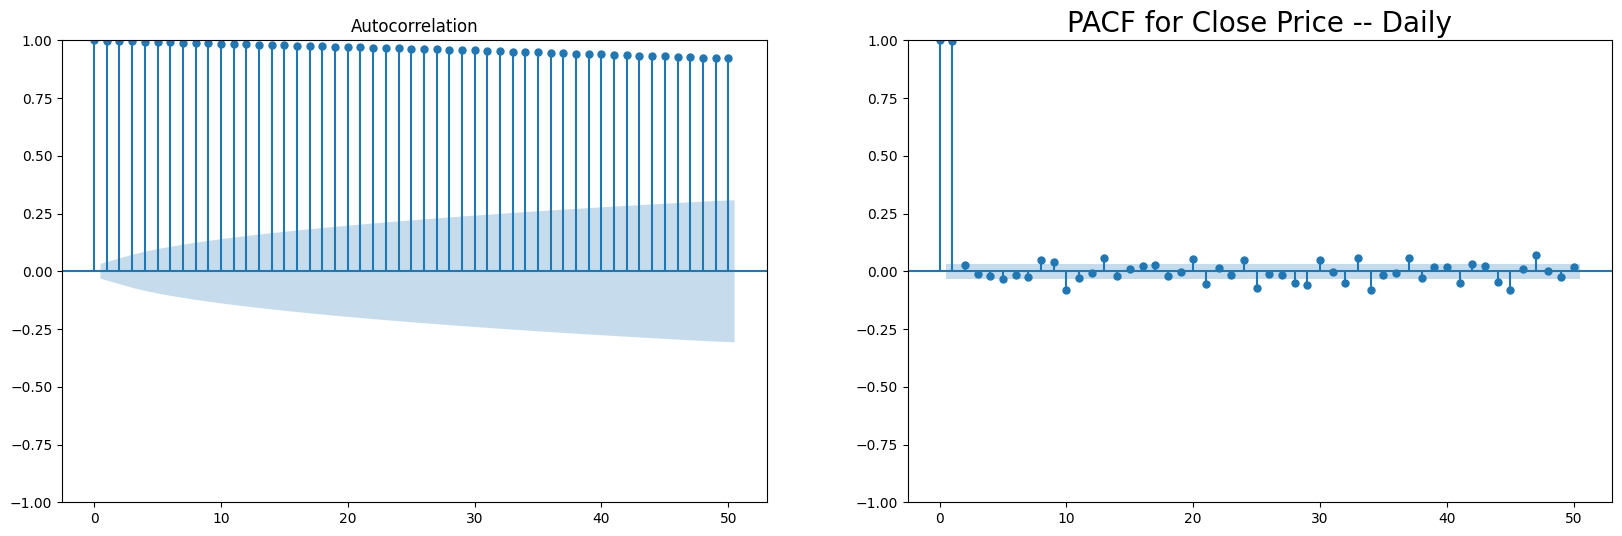

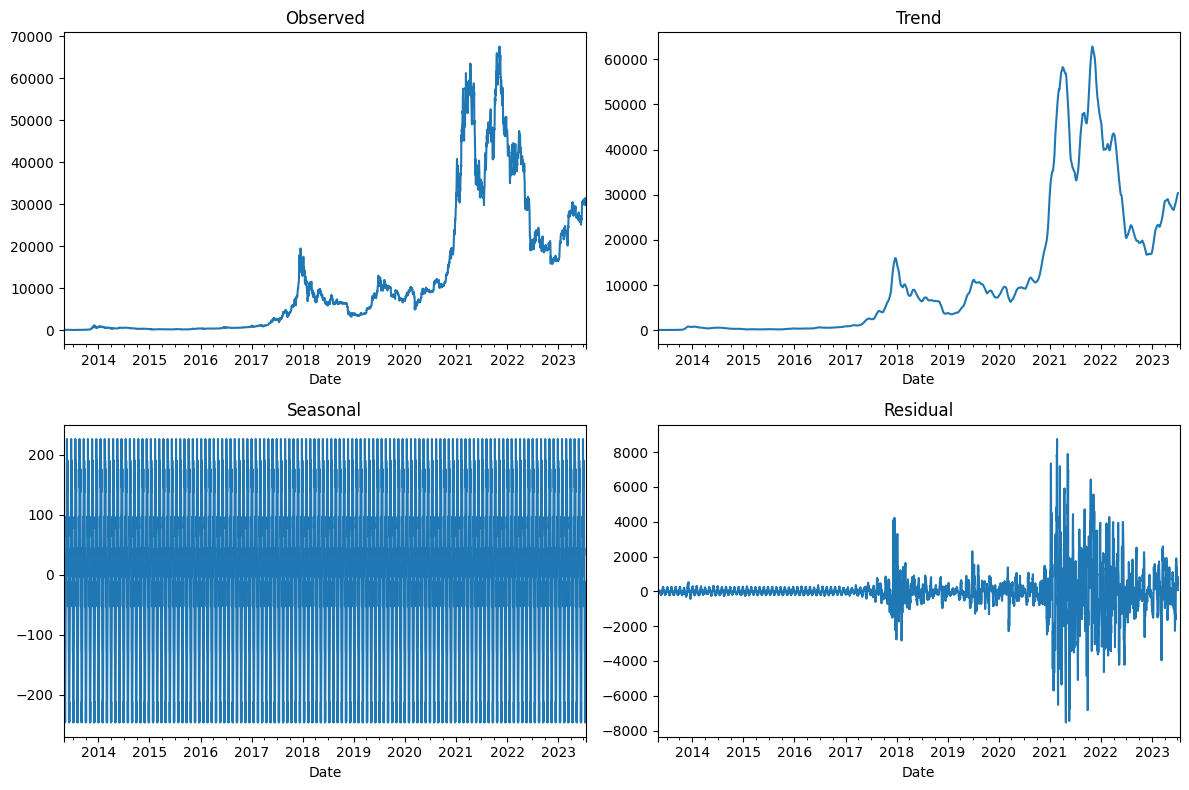

2023-07-22 19:40:27,090 [INFO] - Testing Granger causality



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=829953.1507, p=0.0000  , df_denom=3733, df_num=1
ssr based chi2 test:   chi2=830620.1369, p=0.0000  , df=1
likelihood ratio test: chi2=20206.6970, p=0.0000  , df=1
parameter F test:         F=829953.1507, p=0.0000  , df_denom=3733, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=428471.0533, p=0.0000  , df_denom=3730, df_num=2
ssr based chi2 test:   chi2=858090.8225, p=0.0000  , df=2
likelihood ratio test: chi2=20323.2756, p=0.0000  , df=2
parameter F test:         F=428471.0533, p=0.0000  , df_denom=3730, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=285613.1314, p=0.0000  , df_denom=3727, df_num=3
ssr based chi2 test:   chi2=858448.6982, p=0.0000  , df=3
likelihood ratio test: chi2=20320.3800, p=0.0000  , df=3
parameter F test:         F=285613.1314, p=0.0000  , df_denom=3727, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

{1: ({'ssr_ftest': (829953.150741623, 0.0, 3733.0, 1),
   'ssr_chi2test': (830620.1369329504, 0.0, 1),
   'lrtest': (20206.697023405177, 0.0, 1),
   'params_ftest': (829953.1507416238, 0.0, 3733.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (428471.0532887513, 0.0, 3730.0, 2),
   'ssr_chi2test': (858090.8225380623, 0.0, 2),
   'lrtest': (20323.27555560848, 0.0, 2),
   'params_ftest': (428471.0532887513, 0.0, 3730.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (285613.13143194193, 0.0, 3727.0, 3),
   'ssr_chi2test': (858448.6982293034, 0.0, 3),
   'lrtest': (20320.380018056436, 0.0, 3),
   'params_ftest': (285613.1314319404, 0.0, 3727.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (214029.71227669343, 0.0, 3724.0, 4),
   'ssr_chi2test': (858187.879622875, 0.0, 4),
   'lrtest': (20314.804126515875, 0.0, 4),
   'params_ftest

In [20]:
# Create an instance of the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis(data,target='Close')
tsa.check_stationarity()
tsa.check_volatility()
tsa.check_autocorrelation()
tsa.decompose_time_series()
tsa.test_granger_causality('Open', maxlag=30)

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block 5. - Crypto Data PreProcessing

In [33]:
class DataPreprocessing:
    def __init__(self, data, target_columns, seq_length=5, scaler_path='./scaler.pkl'):
        logger.info("Initializing DataPreprocessing class")
        
        # Check if target_columns exist in data
        if not set(target_columns).issubset(data.columns):
            logger.error(f"Target columns {target_columns} not found in data.")
            raise ValueError(f"Target columns {target_columns} not found in data.")
        
        self.data = data.sort_index(ascending=True)
        self.target_columns = target_columns
        self.seq_length = seq_length
        self.scaler = StandardScaler()
        self.scaler_path = scaler_path

        # If a scaler file exists, load it. Otherwise, fit a new scaler
        if os.path.exists(self.scaler_path):
            self.load_scaler()
            self.data_scaled = self.scaler.transform(self.data[self.target_columns])
        else:
            self.data_scaled = self.scaler.fit_transform(self.data[self.target_columns])
            self.save_scaler()

    def save_scaler(self):
        logger.info("Saving scaler")
        joblib.dump(self.scaler, self.scaler_path)
        logger.info(f"Scaler saved to {self.scaler_path}")

    def load_scaler(self):
        logger.info("Loading scaler")
        try:
            self.scaler = joblib.load(self.scaler_path)
            logger.info(f"Scaler loaded from {self.scaler_path}")
        except Exception as e:
            logger.error(f"Error loading scaler from {self.scaler_path}: {e}")
            raise

    def split_data(self, test_size=0.2):
        logger.info("Splitting data")
        train_data, test_data = train_test_split(self.data_scaled, test_size=test_size, shuffle=False)
        return train_data, test_data

    def prepare_data_rnn(self, data):
        logger.info("Preparing data for RNN")
        X, y = [], []
        for i in range(self.seq_length, len(data)):
            X.append(data[i-self.seq_length:i])
            y.append(data[i, 0])
        X, y = np.array(X), np.array(y)
        logger.info(f"RNN Data Shape - X: {X.shape}, y: {y.shape}")
        return X, y
    
    @staticmethod
    def prepare_data_mlp(data):
        logger.info("Preparing data for MLP")
        X, y = data[:, :-1], data[:, -1]  # Use all columns except the last one as input features (X), and the last column as the target (y)
        logger.info(f"MLP Data Shape - X: {X.shape}, y: {y.shape}")
        return X, y

    def prepare_data_for_tree_based_model(self, target_column='Close', test_size=0.2, scale=False):
        logger.info("Preparing data for tree-based model")
        X = self.data.drop(target_column, axis=1)
        y = self.data[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False)

        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        logger.info(f"Tree Data Shape - X: {X_train.shape}, {y_train.shape} , y: {X_test.shape}, {y_test.shape}")
        return X_train, y_train, X_test, y_test

    def visualize_split(self, train_data, test_data):
        logger.info("Visualizing data split")
        plt.figure(figsize=(14, 7))
        plt.plot(np.arange(len(train_data)), self.scaler.inverse_transform(train_data)[:, 0], color='blue', label='Training Data')
        plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), self.scaler.inverse_transform(test_data)[:, 0], color='orange', label='Testing Data')
        plt.xlabel('Time Step')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()

    def prepare_data_SARIMAX(self, target_column='Close', exog_columns=None, test_size=0.2):
        logger.info("Preparing data for SARIMAX")
        y = self.data[target_column]
        X = self.data[exog_columns] if exog_columns else None

        y_train, y_test = train_test_split(y, test_size=test_size, shuffle=False)
        X_train, X_test = train_test_split(X, test_size=test_size, shuffle=False) if X is not None else (None, None)

        logger.info(f"SARIMAX Data Shape - y: {y_train.shape}, {y_test.shape}")
        return y_train, y_test, X_train, X_test

    def prepare_data_deepar(self):
        logger.info("Preparing data for DeepAR")
        # Add your preferred method to prepare data for AutoTS model
        pass

    def prepare_data_deeptime(self):
        logger.info("Preparing data for DeepTime")
        # Add your preferred method to prepare data for DeepTime model
        pass

In [34]:
# Assuming 'Close' is your target column
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
#preprocessor.visualize_split(train_data, test_data)
X_train_rnn, y_train_rnn = preprocessor.prepare_data_rnn(train_data)
X_test_rnn, y_test_rnn = preprocessor.prepare_data_rnn(test_data)

#preprocessor.visualize_split(train_data, test_data)
X_train_mlp, y_train_mlp = preprocessor.prepare_data_mlp(train_data)
X_test_mlp, y_test_mlp = preprocessor.prepare_data_mlp(test_data)

2023-07-22 19:48:58,781 [INFO] - Initializing DataPreprocessing class
2023-07-22 19:48:58,784 [INFO] - Loading scaler
2023-07-22 19:48:58,787 [INFO] - Scaler loaded from ./scaler.pkl
2023-07-22 19:48:58,791 [INFO] - Splitting data
2023-07-22 19:48:58,793 [INFO] - Preparing data for RNN
2023-07-22 19:48:58,799 [INFO] - RNN Data Shape - X: (2984, 5, 1), y: (2984,)
2023-07-22 19:48:58,800 [INFO] - Preparing data for RNN
2023-07-22 19:48:58,802 [INFO] - RNN Data Shape - X: (743, 5, 1), y: (743,)
2023-07-22 19:48:58,804 [INFO] - Preparing data for MLP
2023-07-22 19:48:58,804 [INFO] - MLP Data Shape - X: (2989, 0), y: (2989,)
2023-07-22 19:48:58,805 [INFO] - Preparing data for MLP
2023-07-22 19:48:58,806 [INFO] - MLP Data Shape - X: (748, 0), y: (748,)


In [35]:
X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn

(array([[[-0.75258551],
         [-0.75314792],
         [-0.7520816 ],
         [-0.75243768],
         [-0.75385238]],
 
        [[-0.75314792],
         [-0.7520816 ],
         [-0.75243768],
         [-0.75385238],
         [-0.75460955]],
 
        [[-0.7520816 ],
         [-0.75243768],
         [-0.75385238],
         [-0.75460955],
         [-0.75508904]],
 
        ...,
 
        [[ 1.27215746],
         [ 1.30741249],
         [ 1.46574581],
         [ 1.45190733],
         [ 1.54404219]],
 
        [[ 1.30741249],
         [ 1.46574581],
         [ 1.45190733],
         [ 1.54404219],
         [ 1.49089033]],
 
        [[ 1.46574581],
         [ 1.45190733],
         [ 1.54404219],
         [ 1.49089033],
         [ 1.39648784]]]),
 array([-0.75460955, -0.75508904, -0.75414098, ...,  1.49089033,
         1.39648784,  1.41737283]),
 array([[[1.46696126],
         [1.50676249],
         [1.40766404],
         [1.4391069 ],
         [1.41469126]],
 
        [[1.50676249],
     

In [36]:
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
# For Linear Regression
X_train_lr, y_train_lr, X_test_lr, y_test_lr = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=True)
# For XGBoost
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=False)
# For LightGBM
X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=False)
# For MLP
X_train_mlp, y_train_mlp, X_test_mlp, y_test_mlp = preprocessor.prepare_data_for_tree_based_model(target_column='Close', test_size=0.2, scale=False)

2023-07-22 19:49:06,146 [INFO] - Initializing DataPreprocessing class
2023-07-22 19:49:06,149 [INFO] - Loading scaler
2023-07-22 19:49:06,152 [INFO] - Scaler loaded from ./scaler.pkl
2023-07-22 19:49:06,156 [INFO] - Splitting data
2023-07-22 19:49:06,158 [INFO] - Preparing data for tree-based model
2023-07-22 19:49:06,165 [INFO] - Tree Data Shape - X: (2989, 5), (2989,) , y: (748, 5), (748,)
2023-07-22 19:49:06,166 [INFO] - Preparing data for tree-based model
2023-07-22 19:49:06,169 [INFO] - Tree Data Shape - X: (2989, 5), (2989,) , y: (748, 5), (748,)
2023-07-22 19:49:06,170 [INFO] - Preparing data for tree-based model
2023-07-22 19:49:06,174 [INFO] - Tree Data Shape - X: (2989, 5), (2989,) , y: (748, 5), (748,)
2023-07-22 19:49:06,174 [INFO] - Preparing data for tree-based model
2023-07-22 19:49:06,178 [INFO] - Tree Data Shape - X: (2989, 5), (2989,) , y: (748, 5), (748,)


In [37]:
X_train_mlp, y_train_mlp, X_test_mlp, y_test_mlp

(                Open      High       Low          Volume       Market Cap
 Date                                                                     
 2013-04-27   139.410   147.410   124.440       59902.290   1515587582.880
 2013-04-28   136.690   143.370   110.850       25956.840   1419007893.660
 2013-04-29   134.440   147.490   134.000           0.000   1603768864.500
 2013-04-30   144.000   146.930   134.050           0.000   1542813125.000
 2013-05-01   139.000   139.890   107.720           0.000   1298954593.750
 ...              ...       ...       ...             ...              ...
 2021-06-28 34679.120 35219.890 33902.080 33892523752.030 645442759493.210
 2021-06-29 34475.560 36542.110 34252.480 37901460044.300 672333423401.870
 2021-06-30 35908.390 36074.760 34086.150 34059036099.040 656852513237.540
 2021-07-01 35035.980 35035.980 32883.780 37838957079.150 629339325297.740
 2021-07-02 33549.600 33939.590 32770.680 38728974942.250 635450784106.090
 
 [2989 rows x 5 columns

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block X - LSTM Class

In [38]:
class LSTM_Models:
    def __init__(self, input_shape, units, dropout, dense_units, optimizer, scaler, X_train, y_train, X_test, y_test,cross_val=False):
        logging.info("Initializing LSTM model")
        self.model = Sequential()
        for i, unit in enumerate(units):
            return_sequences = True if i < len(units) - 1 else False
            self.model.add(LSTM(units=unit, input_shape=input_shape, return_sequences=return_sequences))
            self.model.add(Dropout(dropout))
        self.model.add(Dense(units=dense_units))
        self.model.compile(optimizer=optimizer, loss='mean_squared_error')
        self.model.summary()
        self.cross_val = cross_val
        self.scaler = scaler
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.params = {
            'input_shape': input_shape,
            'units': units,
            'dropout': dropout,
            'dense_units': dense_units,
            'optimizer': optimizer
        }

    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logging.info("Training LSTM model")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None
        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            self.history = []
            fold_no = 1
            for train, val in tscv.split(self.X_train):
                logging.info(f"Training on fold {fold_no}")
                history = self.model.fit(self.X_train[train], self.y_train[train], epochs=epochs, 
                                         batch_size=batch_size, validation_data=(self.X_train[val], self.y_train[val]), 
                                         callbacks=callbacks, shuffle=False)
                self.history.append(history)
                logging.info(f"Done with fold {fold_no}")
                fold_no += 1
        else:
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, 
                                          batch_size=batch_size, validation_split=0.2, 
                                          callbacks=callbacks, shuffle=False)
        logging.info("Training completed")

    def make_predictions(self):
        logging.info("Making predictions with LSTM model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

        # Unscaled the predictions
        self.train_predictions = self.scaler.inverse_transform(self.train_predictions)
        self.test_predictions = self.scaler.inverse_transform(self.test_predictions)

        self.train_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_train.reshape(-1, 1)).flatten(), 
                                                 'Predicted': self.train_predictions.squeeze()})
        self.test_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten(), 
                                                'Predicted': self.test_predictions.squeeze()})
        logging.info("Predictions made")

    def evaluate_model(self):
        logging.info("Evaluating LSTM model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'], 
                                          squared=False)
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'], 
                                         squared=False)
            else:
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'])
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'])
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        logging.info("Evaluation completed")
        return self.evaluation_df

    def plot_history(self):
        logging.info("Plotting training history")
        plt.figure(figsize=(14, 7))

        if self.cross_val:
            # Loop through the history of each fold
            for i, history in enumerate(self.history):
                plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
                plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
        else:
            plt.plot(self.history.history['loss'], label='Training Loss')
            plt.plot(self.history.history['val_loss'], label='Validation Loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        logging.info("Plotting completed")

    def plot_predictions(self):
        logging.info("Plotting predictions")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        axes[0].plot(self.train_comparison_df['Actual'], label='Actual')
        axes[0].plot(self.train_comparison_df['Predicted'], label='Predicted')
        axes[0].set_title('Training Data')
        axes[0].legend()

        axes[1].plot(self.test_comparison_df['Actual'], label='Actual')
        axes[1].plot(self.test_comparison_df['Predicted'], label='Predicted')
        axes[1].set_title('Testing Data')
        axes[1].legend()

        plt.show()
        logging.info("Plotting completed")
            
    def save_model(self):
        # Create a model name based on the parameters
        model_name = f"LSTM_model_{str(self.params).replace(' ', '').replace(':', '').replace(',', '_')}.h5"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        self.model.save(model_path)
        logging.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load_model(model_path)
        logging.info(f"Model loaded from {model_path}")
        return loaded_model

# Block X - LSTM Models 

In [ ]:
# After preparing your data with the DataPreprocessing class...
lstm_model = LSTM_Models(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), 
                         units=[256, 128], 
                         dropout=0.2, 
                         dense_units=1, 
                         optimizer='adam', 
                         scaler=preprocessor.scaler, 
                         X_train=X_train_rnn, 
                         y_train=y_train_rnn, 
                         X_test=X_test_rnn, 
                         y_test=y_test_rnn,
                        cross_val=False)

lstm_model.train_model(epochs=100, batch_size=32, early_stopping=True)
lstm_model.save_model()  # save the model
lstm_model.make_predictions()

In [ ]:
lstm_model.evaluate_model()
lstm_model.plot_history()
lstm_model.plot_predictions()

In [ ]:
# After preparing your data with the DataPreprocessing class...
lstm_model1 = LSTM_Models(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), 
                         units=[256], 
                         dropout=0.2, 
                         dense_units=1, 
                         optimizer='adam', 
                         scaler=preprocessor.scaler, 
                         X_train=X_train_rnn, 
                         y_train=y_train_rnn, 
                         X_test=X_test_rnn, 
                         y_test=y_test_rnn)

lstm_model1.train_model(epochs=100, batch_size=32, early_stopping=True)
lstm_model.save_model()  # save the model
lstm_model1.make_predictions()

In [ ]:
lstm_model1.evaluate_model()
lstm_model1.plot_history()
lstm_model1.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block X - MLP Model

In [41]:
class MLP_Models:
    def __init__(self, input_shape, units, dropout, dense_units, optimizer, scaler, X_train, y_train, X_test, y_test, cross_val=False):
        logging.info("Initializing MLP model")
        self.model = Sequential()
        for unit in units:
            self.model.add(Dense(units=unit, activation="relu"))
            self.model.add(Dropout(dropout))
        self.model.add(Dense(units=dense_units))
        self.model.compile(optimizer=optimizer, loss='mean_squared_error')
        self.cross_val = cross_val
        self.scaler = scaler
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        self.params = {
            'input_shape': input_shape,
            'units': units,
            'dropout': dropout,
            'dense_units': dense_units,
            'optimizer': optimizer
        }
        
        self.model.build(input_shape=input_shape)  # Build the model directly in the constructor
        self.model.summary()
        
    def build_model(self):
        logging.info("Building MLP model")
        self.model.build(input_shape=self.params['input_shape'])  # Use self.params to access the input shape
        logging.info("Model built")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        self.build_model()  # Build the model before training
        logging.info("Training MLP model")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None
        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            self.history = []
            fold_no = 1
            for train, val in tscv.split(self.X_train):
                logging.info(f"Training on fold {fold_no}")
                history = self.model.fit(self.X_train[train], self.y_train[train], epochs=epochs, 
                                         batch_size=batch_size, validation_data=(self.X_train[val], self.y_train[val]), 
                                         callbacks=callbacks, shuffle=False)
                self.history.append(history)
                logging.info(f"Done with fold {fold_no}")
                fold_no += 1
        else:
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, 
                                          batch_size=batch_size, validation_split=0.2, 
                                          callbacks=callbacks, shuffle=False)
        logging.info("Training completed")


    def make_predictions(self):
        logging.info("Making predictions with MLP model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

        # Unscaled the predictions
        self.train_predictions = self.scaler.inverse_transform(self.train_predictions)
        self.test_predictions = self.scaler.inverse_transform(self.test_predictions)

        self.train_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_train.reshape(-1, 1)).flatten(), 
                                                 'Predicted': self.train_predictions.squeeze()})
        self.test_comparison_df = pd.DataFrame({'Actual': self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten(), 
                                                'Predicted': self.test_predictions.squeeze()})
        logging.info("Predictions made")

    def evaluate_model(self):
        logging.info("Evaluating MLP model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'], 
                                          squared=False)
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'], 
                                         squared=False)
            else:
                train_evaluation = metric(self.train_comparison_df['Actual'], 
                                          self.train_comparison_df['Predicted'])
                test_evaluation = metric(self.test_comparison_df['Actual'], 
                                         self.test_comparison_df['Predicted'])
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        logging.info("Evaluation completed")
        return self.evaluation_df

    def plot_history(self):
        logging.info("Plotting training history")
        plt.figure(figsize=(14, 7))

        if self.cross_val:
            # Loop through the history of each fold
            for i, history in enumerate(self.history):
                plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
                plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
        else:
            plt.plot(self.history.history['loss'], label='Training Loss')
            plt.plot(self.history.history['val_loss'], label='Validation Loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        logging.info("Plotting completed")

    def plot_predictions(self):
        logging.info("Plotting predictions")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        axes[0].plot(self.train_comparison_df['Actual'], label='Actual')
        axes[0].plot(self.train_comparison_df['Predicted'], label='Predicted')
        axes[0].set_title('Training Data')
        axes[0].legend()

        axes[1].plot(self.test_comparison_df['Actual'], label='Actual')
        axes[1].plot(self.test_comparison_df['Predicted'], label='Predicted')
        axes[1].set_title('Testing Data')
        axes[1].legend()

        plt.show()
        logging.info("Plotting completed")
            
    def save_model(self):
        # Create a model name based on the parameters
        model_name = f"MLP_model_{str(self.params).replace(' ', '').replace(':', '').replace(',', '_')}.h5"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        self.model.save(model_path)
        logging.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load_model(model_path)
        logging.info(f"Model loaded from {model_path}")
        return loaded_model

In [46]:
print(X_train_mlp.shape,y_train_mlp.shape,X_test_mlp.shape,y_test_mlp.shape)


(2989, 5) (2989,) (748, 5) (748,)


In [47]:
mlp_model = MLP_Models(
    input_shape=(X_train_mlp.shape[1],),  # Input shape should be (num_features,)
    units=[256, 128],
    dropout=0.2,
    dense_units=1,
    optimizer='adam',
    scaler=preprocessor.scaler,
    X_train=X_train_mlp,
    y_train=y_train_mlp,  # Reshape y_train to (n_samples, 1)
    X_test=X_test_mlp,
    y_test=y_test_mlp,   # Reshape y_test to (n_samples, 1)
    cross_val=False
)

# Train the model with early stopping
mlp_model.train_model(epochs=100, batch_size=32, early_stopping=True)
mlp_model.save_model()
mlp_model.make_predictions()

2023-07-22 19:51:55,487 [INFO] - Initializing MLP model


ValueError: Input 0 of layer "dense_6" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (5,)

In [48]:
mlp_model.evaluate_model()
mlp_model.plot_history()
mlp_model.plot_predictions()

NameError: name 'mlp_model' is not defined

# Block Y - Linear Model

# ------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
class Linear_Regression:
    def __init__(self, X_train, y_train, X_test, y_test,cross_val=False):
        logger.info("Initializing Linear_Regression class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = LinearRegression()

    def train_model(self):
        logger.info("Training Linear Regression model")
        
        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train[train_index], self.X_train[test_index]
                cv_train_y, cv_val_y = self.y_train[train_index], self.y_train[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        logger.info("Making predictions with Linear Regression model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        logger.info("Evaluating Linear Regression model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        logger.info("Plotting predictions")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()
        
    def save_model(self):
        model_name = "linear_regression.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model



In [ ]:
lr_model = Linear_Regression(X_train_lr, y_train_lr, X_test_lr, y_test_lr, cross_val=True)
lr_model.train_model()
lr_model.save_model()  # save the model
lr_model.make_predictions()
evaluation_df = lr_model.evaluate_model()
print(evaluation_df)
lr_model.plot_predictions()


# ------------------------------------------------------------------------------------------------------------------------------------------

# Block Z - XGBoost Model

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

class XGBoostModel:
    def __init__(self, X_train, y_train, X_test, y_test, cross_val=False):
        logger.info("Initializing XGBoostModel class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = XGBRegressor(objective='reg:squarederror')

    def train_model(self):
        logger.info("Training XGBoost model")

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                cv_train_y, cv_val_y = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def save_model(self):
        model_name = "xgboost_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model

In [ ]:
xgb_model = XGBoostModel(X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb,cross_val=False)
xgb_model.train_model()
xgb_model.save_model()  # save the model
xgb_model.make_predictions()
evaluation_df = xgb_model.evaluate_model()
print(evaluation_df)
xgb_model.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------

# Block Z1 - LightGBM Model

In [ ]:
class LightGBMModel:
    def __init__(self, X_train, y_train, X_test, y_test, cross_val=False):
        logger.info("Initializing LightGBMModel class")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cross_val = cross_val
        self.model = LGBMRegressor()

    def train_model(self):
        logger.info("Training LightGBM model")

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            fold_no = 1
            for train_index, test_index in tscv.split(self.X_train):
                logger.info(f"Performing cross validation on fold {fold_no}")
                cv_train_x, cv_val_x = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                cv_train_y, cv_val_y = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                self.model.fit(cv_train_x, cv_train_y)
                cv_val_predictions = self.model.predict(cv_val_x)
                cv_val_score = mean_squared_error(cv_val_y, cv_val_predictions, squared=False)
                logger.info(f"Cross-validation score on fold {fold_no}: {cv_val_score}")
                fold_no += 1
        else:
            self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        logger.info("Making predictions with LightGBM model")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

    def evaluate_model(self):
        logger.info("Evaluating LightGBM model")
        metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score, 
                   'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

        evaluation = {}
        for name, metric in metrics.items():
            if name == 'RMSE':
                train_evaluation = metric(self.y_train, self.train_predictions, squared=False)
                test_evaluation = metric(self.y_test, self.test_predictions, squared=False)
            else:
                train_evaluation = metric(self.y_train, self.train_predictions)
                test_evaluation = metric(self.y_test, self.test_predictions)
            evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

        self.evaluation_df = pd.DataFrame(evaluation)
        return self.evaluation_df

    def plot_predictions(self):
        logger.info("Plotting predictions")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

        ax[0].plot(self.y_train, label='Actual')
        ax[0].plot(self.y_train.index, self.train_predictions, label='Predicted')
        ax[0].set_title('Train Data: Actual vs Predicted')
        ax[0].legend()

        ax[1].plot(self.y_test, label='Actual')
        ax[1].plot(self.y_test.index, self.test_predictions, label='Predicted')
        ax[1].set_title('Test Data: Actual vs Predicted')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    def save_model(self):
        model_name = "lightgbm_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model


In [ ]:
lgb_model = LightGBMModel(X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, cross_val=False)
lgb_model.train_model()
lgb_model.save_model()  # save the model
lgb_model.make_predictions()
evaluation_df = lgb_model.evaluate_model()
print(evaluation_df)
lgb_model.plot_predictions()


# ------------------------------------------------------------------------------------------------------------------------------------------

# Block 9 - AutoArima

In [ ]:
# Assuming 'Close' is your target column
preprocessor = DataPreprocessing(data, ['Close'])
scaled_data = preprocessor.data_scaled
train_data, test_data = preprocessor.split_data(test_size=0.2)
y_train, y_test, X_train, X_test = preprocessor.prepare_data_SARIMAX('Close', ['Volume'])
y_train, y_test, X_train, X_test = preprocessor.prepare_data_SARIMAX('Close')

In [ ]:
class SARIMAModel:
    def __init__(self, train, test, exog_train=None, exog_test=None):
        logger.info("Initializing SARIMAModel class")
        self.train = train
        self.test = test
        self.exog_train = exog_train
        self.exog_test = exog_test
        self.model = None
        self.predictions = None

    def auto_fit(self, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True):
        logger.info("Starting auto_fit...")
        try:
            self.model = pm.auto_arima(self.train, exogenous=self.exog_train, seasonal=seasonal, m=m, trace=trace, error_action=error_action, suppress_warnings=suppress_warnings)
            logger.info("Auto_fit completed successfully.")
        except Exception as e:
            logger.error(f"Auto_fit failed with error: {e}")
            raise

    def make_predictions(self,start, end):
        if self.model is None:
            logger.error("Model not fitted yet.")
            return
        logger.info("Making predictions...")
        self.predictions = self.model.predict(n_periods=len(self.test), exogenous=self.exog_test)
        return self.predictions
    
    def evaluate_model(self):
        if self.model is None or self.predictions is None:
            logger.error("Model not fitted or predictions not made yet.")
            return
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        r2 = r2_score(self.test, self.predictions)
        
        logger.info(f'MSE: {mse}')
        logger.info(f'MAE: {mae}')
        logger.info(f'R2 Score: {r2}')

    def plot_predictions(self):
        if self.model is None or self.predictions is None:
            logger.error("Model not fitted or predictions not made yet.")
            return
        logger.info("Plotting predictions")
        plt.figure(figsize=(10,5))
        plt.plot(self.test, label='Actual')
        plt.plot(self.predictions, label='Predicted')
        plt.title('Test Data vs Predicted Data')
        plt.legend()
        plt.show()

    def save_model(self):
        model_name = "sarima_model.joblib"
        model_path = os.path.join("trained_models", model_name)

        # Save the model
        dump(self.model, model_path)
        logger.info(f"Model saved at {model_path}")

    @staticmethod
    def load_model(model_path):
        # Load the model
        loaded_model = load(model_path)
        logger.info(f"Model loaded from {model_path}")
        return loaded_model

In [ ]:
# Initialize the SARIMAModel class
model = SARIMAModel(y_train, y_test)# Fit the SARIMA model with seasonal set to True and m set to 12 for monthly data
model.auto_fit(seasonal=True, m=12)
model.save_model()  # save the model
# Make predictions for the length of the test set
model.make_predictions(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# Evaluate the model
model.evaluate_model()
# Plot the actual vs predicted values
model.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------Part 2------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
class DataPreprocessing:
    def __init__(self, data, target_columns, model_name, seq_length=5):
        logger.info("Initializing DataPreprocessing class")
        
        # Check if target_columns exist in data
        if not set(target_columns).issubset(data.columns):
            logger.error(f"Target columns {target_columns} not found in data.")
            raise ValueError(f"Target columns {target_columns} not found in data.")
        
        self.data = data.sort_index(ascending=True)
        self.target_columns = target_columns
        self.seq_length = seq_length
        self.scaler = StandardScaler()
        self.model_name = model_name
        self.scaler_path = f'./assets/scaler_{model_name}.pkl'

        # If a scaler file exists, load it. Otherwise, fit a new scaler
        if os.path.exists(self.scaler_path):
            self.load_scaler()
            self.data_scaled = self.scaler.transform(self.data[self.target_columns])
        else:
            self.data_scaled = self.scaler.fit_transform(self.data[self.target_columns])
            self.save_scaler()

    def save_scaler(self):
        logger.info("Saving scaler")
        joblib.dump(self.scaler, self.scaler_path)
        logger.info(f"Scaler saved to {self.scaler_path}")

    def load_scaler(self):
        logger.info("Loading scaler")
        try:
            self.scaler = joblib.load(self.scaler_path)
            logger.info(f"Scaler loaded from {self.scaler_path}")
        except Exception as e:
            logger.error(f"Error loading scaler from {self.scaler_path}: {e}")
            raise

    def split_data(self, test_size=0.2):
        logger.info("Splitting data")
        train_data, test_data = train_test_split(self.data_scaled, test_size=test_size, shuffle=False)
        return train_data, test_data

    def prepare_data_rnn(self, data):
        logger.info("Preparing data for RNN")
        X, y = [], []
        for i in range(self.seq_length, len(data)):
            X.append(data[i-self.seq_length:i])
            y.append(data[i, 0])
        X, y = np.array(X), np.array(y)
        logger.info(f"RNN Data Shape - X: {X.shape}, y: {y.shape}")
        return X, y   

    def prepare_data_for_tree_based_model(self, target_column='Close', test_size=0.2, scale=False):
        logger.info("Preparing data for tree-based model")
        X = self.data.drop(target_column, axis=1)
        y = self.data[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False)

        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        logger.info(f"Tree Data Shape - X: {X_train.shape}, {y_train.shape} , y: {X_test.shape}, {y_test.shape}")
        return X_train, y_train, X_test, y_test

    def visualize_split(self, train_data, test_data):
        logger.info("Visualizing data split")
        plt.figure(figsize=(14, 7))
        plt.plot(np.arange(len(train_data)), self.scaler.inverse_transform(train_data)[:, 0], color='blue', label='Training Data')
        plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), self.scaler.inverse_transform(test_data)[:, 0], color='orange', label='Testing Data')
        plt.xlabel('Time Step')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()
    
    def prepare_data_prophet(self, target_col, regressor_cols=None, model_type='uni', normalize=False):
        logging.info("Preparing data for Prophet model")
        if target_col not in self.data.columns:
            logger.error(f"Target column {target_col} not found in data.")
            raise ValueError(f"Target column {target_col} not found in data.")
        if regressor_cols:
            for col in regressor_cols:
                if col not in self.data.columns:
                    logger.error(f"Regressor column {col} not found in data.")
                    raise ValueError(f"Regressor column {col} not found in data.")
        if not isinstance(self.data.index, pd.DatetimeIndex):
            logger.error("Index of DataFrame is not date.")
            raise ValueError("Index of DataFrame is not date.")

        columns_to_keep = ['Date', target_col] + (regressor_cols if regressor_cols else [])
        data_prophet = self.data.reset_index()[columns_to_keep].rename(columns={'Date': 'ds', target_col: 'y'})

        # Normalize if required
        if normalize:
            scaler_path = f'./assets/scaler_{model_type}.pkl'  # update the path here
            if not os.path.exists(scaler_path):
                logger.error(f"No scaler file found at {scaler_path}")
                raise ValueError(f"No scaler file found at {scaler_path}")
            scaler = joblib.load(scaler_path)
            if regressor_cols:
                data_prophet[regressor_cols] = scaler.transform(data_prophet[regressor_cols])
            data_prophet['y'] = scaler.transform(data_prophet[['y']])

        return data_prophet

In [ ]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

In [ ]:
# Instantiate the DataPreprocessing class
target_columns = ['Close']
preprocessor_uni = DataPreprocessing(data, target_columns, model_name='prophet_uni')
data_prophet_uni = preprocessor_uni.prepare_data_prophet(target_col='Close', model_type='uni', normalize=True)
data_prophet_uni

In [ ]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

# Block X - Prophet Model

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import joblib
import logging

class CryptoProphet:
    def __init__(self, model_name, data, target_column, regressor_cols=None):
        logger.info("Initializing Prophet Model")
        self.model_name = model_name
        self.data = data
        self.target_column = target_column
        self.regressor_cols = regressor_cols if regressor_cols else []
        self.model = Prophet()
        self.model_path = f'./trained_models/model_{model_name}.pkl'
        for regressor in self.regressor_cols:
            self.model.add_regressor(regressor)
        
    def train(self):
        logger.info("Training Prophet Model")
        self.model.fit(self.data)

    def save_model(self):
        logger.info("Saving Prophet Model")
        joblib.dump(self.model, self.model_path)
        logger.info(f"Model saved to {self.model_path}")

    def load_model(self):
        logger.info("Loading Prophet Model")
        if os.path.exists(self.model_path):
            self.model = joblib.load(self.model_path)
            logger.info(f"Model loaded from {self.model_path}")
        else:
            logger.error(f"No model file found at {self.model_path}")
            raise ValueError(f"No model file found at {self.model_path}")

    def make_future_dataframe(self, periods, freq='D'):
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        return future

    def predict(self, future):
        logger.info("Making Predictions")
        forecast = self.model.predict(future)
        return forecast

    def plot_predictions(self, forecast):
        logger.info("Plotting Predictions")
        self.model.plot(forecast)
        plt.show()

    def evaluate(self, forecast):
        logger.info("Evaluating Model")
        y_true = self.data[self.target_column].values
        y_pred = forecast['yhat'].values[:len(y_true)]
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        logger.info(f"MSE: {mse}, MAE: {mae}")
        return mse, mae


In [ ]:
# Assuming that data_prophet_uni has been created
prophet_uni = CryptoProphet(model_name='prophet_uni', data=data_prophet_uni, target_column='y')
prophet_uni.train()
prophet_uni.save_model()

# Make future dataframe for predictions
future = prophet_uni.make_future_dataframe(periods=30)

# Predict and plot
forecast = prophet_uni.predict(future)
prophet_uni.plot_predictions(forecast)

# Evaluate model
mse, mae = prophet_uni.evaluate(forecast)


In [ ]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

# Block X - Prophet Pre-Pro

In [ ]:
import pandas as pd
import numpy as np

class DataPreprocessor:
    """
    This class is responsible for preprocessing data for different models.

    Input:
        data (pd.DataFrame): The raw data.

    Methods:
        get_markov_data: Returns the transition matrix and start state for a Markov chain model.
        get_exp_smoothing_data: Returns the time series data for an Exponential Smoothing model.
        get_mlp_data: Returns the input and output sequences for an MLP model.
    """

    def __init__(self, data):
        self.data = data

    def get_markov_data(self, n_states):
        # Discretize the data into n_states states
        self.data['State'] = pd.qcut(self.data['Close'], q=n_states, labels=False)

        # Compute the transition matrix efficiently
        state_shifted = self.data['State'].shift().fillna(-1).astype(int)
        transition_matrix = np.zeros((n_states, n_states))
        for i in range(n_states):
            for j in range(n_states):
                transition_matrix[i, j] = np.sum((state_shifted == i) & (self.data['State'] == j))
        transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)

        # Use the state of the last day as the start state
        start_state = self.data['State'].iloc[-1]

        return transition_matrix, start_state

    def get_exp_smoothing_data(self):
        # Use the 'Close' prices as the time series data
        return self.data['Close'].values

    def get_mlp_data(self, look_back):
        # Transform the 'Close' prices into input and output sequences
        data = self.data['Close'].values
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        return np.array(X), np.array(y)

In [ ]:
preprocessor = DataPreprocessing(data)
transition_matrix, start_state = preprocessor.get_markov_data(5)
time_series_data = preprocessor.get_exp_smoothing_data()
X, y = preprocessor.get_mlp_data(10)

# Markov Chains

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

class MarkovChain:
    def __init__(self, transition_matrix, start_state, model_path):
        self.transition_matrix = transition_matrix
        self.current_state = start_state
        self.model_path = model_path
        logger.info("MarkovChain initialized.")

    def simulate(self, n_steps):
        logger.info(f"Simulating {n_steps} steps with MarkovChain.")
        states = [self.current_state]
        for _ in range(n_steps):
            rand = np.random.rand()
            next_state = np.where(self.transition_matrix[self.current_state, :].cumsum() > rand)[0][0]
            self.current_state = next_state
            states.append(self.current_state)
        return states

    def save_model(self):
        joblib.dump(self, self.model_path)
        logger.info(f"MarkovChain model saved to {self.model_path}.")

    @classmethod
    def load_model(cls, model_path):
        if os.path.exists(model_path):
            logger.info(f"Loading MarkovChain model from {model_path}.")
            return joblib.load(model_path)
        else:
            raise ValueError(f"No model file found at {model_path}")

    def predict(self, n_steps):
        logger.info(f"Making predictions for {n_steps} steps with MarkovChain.")
        return self.simulate(n_steps)

    def plot_predictions(self, predictions):
        logger.info("Plotting predictions.")
        plt.plot(predictions)
        plt.show()

    def evaluate(self, true_values, predicted_values):
        mse = mean_squared_error(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, predicted_values)
        logger.info("Evaluation completed.")
        return mse, rmse, mae, r2


In [ ]:
# Initialize CryptoData class and get the data
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

# Initialize DataPreprocessing class with the obtained data
preprocessor = DataPreprocessing(data)

# For MarkovChain model
transition_matrix, start_state = preprocessor.get_markov_data(5)
markov_chain = MarkovChain(transition_matrix, start_state, "markov_model_path.joblib")
predictions_markov = markov_chain.predict(10)
markov_chain.save_model()

# Exponential Smoothing

In [ ]:
class ExponentialSmoothing:
    def __init__(self, data, alpha, model_path):
        self.data = data
        self.alpha = alpha
        self.smoothed = [self.data[0]]
        self.model_path = model_path
        logger.info("ExponentialSmoothing initialized.")

    def smooth(self):
        logger.info("Performing Exponential Smoothing.")
        for i in range(1, len(self.data)):
            smoothed_value = self.alpha * self.data[i] + (1 - self.alpha) * self.smoothed[-1]
            self.smoothed.append(smoothed_value)
        return self.smoothed

    def save_model(self):
        joblib.dump(self, self.model_path)
        logger.info(f"ExponentialSmoothing model saved to {self.model_path}.")

    @classmethod
    def load_model(cls, model_path):
        if os.path.exists(model_path):
            logger.info(f"Loading ExponentialSmoothing model from {model_path}.")
            return joblib.load(model_path)
        else:
            raise ValueError(f"No model file found at {model_path}")

    def predict_next(self):
        logger.info("Predicting the next value.")
        return self.smoothed[-1]

    def plot_predictions(self, predictions):
        logger.info("Plotting predictions.")
        plt.plot(predictions)
        plt.show()

    def evaluate(self, true_values, predicted_values):
        mse = mean_squared_error(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, predicted_values)
        logger.info("Evaluation completed.")
        return mse, rmse, mae, r2

In [ ]:
# Initialize CryptoData class and get the data
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()

# Initialize DataPreprocessing class with the obtained data
preprocessor = DataPreprocessing(data)
time_series_data = preprocessor.get_exp_smoothing_data()
exp_smoothing = ExponentialSmoothing(time_series_data, alpha, "exp_smoothing_model_path.joblib")
smoothed_data = exp_smoothing.smooth()
exp_smoothing.save_model()

# MLP Model

In [ ]:
class MLPModel:
    def __init__(self, X_train, y_train, look_back, model_path):
        self.model = Sequential()
        self.model.add(Dense(10, input_shape=(look_back, 1), activation="relu"))
        self.model.add(Dense(5, activation="relu"))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer="adam")
        self.X_train = X_train
        self.y_train = y_train
        self.model_path = model_path
        logger.info("MLPModel initialized.")

    def train(self, epochs=50, batch_size=32, verbose=2):
        logger.info("Training MLPModel.")
        self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        logger.info("MLPModel training completed.")

    def save_model(self):
        self.model.save(self.model_path)
        logger.info(f"MLPModel saved to {self.model_path}.")

    def load_model(self):
        if os.path.exists(self.model_path):
            logger.info(f"Loading MLPModel from {self.model_path}.")
            self.model = keras.models.load_model(self.model_path)
        else:
            raise ValueError(f"No model file found at {self.model_path}")

    def predict(self, X_test):
        logger.info("Making predictions with MLPModel.")
        return self.model.predict(X_test)

    def plot_predictions(self, true_values, predicted_values):
        logger.info("Plotting predictions.")
        plt.plot(true_values)
        plt.plot(predicted_values)
        plt.show()

    def evaluate(self, true_values, predicted_values):
        mse = mean_squared_error(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, predicted_values)
        logger.info("Evaluation completed.")
        return mse, rmse, mae, r2

In [ ]:
# Markov Model - Hard coded needs to be made into a class and to add a function to the data-pre-processing class before passing to the markov model chain

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
df = data1.copy()
df["Date"] = pd.to_datetime(df["Date"])
df["Return"] = df["Close"].pct_change()
df["Return"] = df["Return"].fillna(df["Return"].mean())
df = df[np.abs(df["Return"] - df["Return"].mean()) <= 3 * df["Return"].std()]

# Define the number of states for the Markov chain
n_states = 3

# Cluster the returns into n_states using k-means algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_states, random_state=0).fit(df["Return"].values.reshape(-1, 1))
df["State"] = kmeans.predict(df["Return"].values.reshape(-1, 1))

# Plot the states on the price chart
plt.figure(figsize=(12, 8))
plt.plot(df["Date"], df["Close"], label="Price")
for i in range(n_states):
    plt.scatter(df[df["State"] == i]["Date"], df[df["State"] == i]["Close"], label=f"State {i}")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BTC Price and States")
plt.show()

# Estimate the transition matrix for the Markov chain
trans_mat = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        # Count the number of transitions from state i to state j
        trans_mat[i, j] = len(df[(df["State"].shift(1) == i) & (df["State"] == j)])
    # Normalize the row to sum to 1
    trans_mat[i, :] = trans_mat[i, :] / trans_mat[i, :].sum()

# Print the transition matrix
print("Transition matrix:")
print(trans_mat)

# Define a function to simulate the Markov chain
def simulate_markov_chain(trans_mat, start_state, n_steps):
    # Initialize an empty list to store the states
    states = []
    # Set the current state to the start state
    current_state = start_state
    # Append the current state to the list
    states.append(current_state)
    # Loop for n_steps times
    for _ in range(n_steps):
        # Draw a random number between 0 and 1
        rand = np.random.rand()
        # Find the next state based on the transition matrix and the random number
        next_state = np.where(trans_mat[current_state, :].cumsum() > rand)[0][0]
        # Set the current state to the next state
        current_state = next_state
        # Append the current state to the list
        states.append(current_state)
    # Return the list of states
    return states

# Simulate the Markov chain for 10 steps starting from state 0
sim_states = simulate_markov_chain(trans_mat, start_state=0, n_steps=10)

# Print the simulated states
print("Simulated states:")
print(sim_states)

# Calculate the expected return for each state based on the historical data
state_returns = df.groupby("State")["Return"].mean()

# Print the expected returns
print("Expected returns:")
print(state_returns)

# Calculate the predicted price for each simulated state based on the last price and the expected return
last_price = df["Close"].iloc[-1]
pred_prices = [last_price]
for state in sim_states:
    pred_price = pred_prices[-1] * (1 + state_returns[state])
    pred_prices.append(pred_price)

# Print the predicted prices
print("Predicted prices:")
print(pred_prices)

# Plot the predicted prices on a chart
plt.figure(figsize=(12, 8))
plt.plot(range(len(pred_prices)), pred_prices, marker="o", label="Predicted")
plt.xlabel("Step")
plt.ylabel("Price")
plt.title("BTC Price Prediction using Markov Chain")
plt.show()


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
df = data1.copy()
# Convert the date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Define the smoothing parameter alpha
alpha = 0.2

# Initialize the first smoothed value as the first price
smoothed = [df["Close"].iloc[0]]

# Loop through the rest of the prices
for i in range(1, len(df)):
    # Apply the exponential smoothing formula
    smoothed_value = alpha * df["Close"].iloc[i] + (1 - alpha) * smoothed[-1]
    # Append the smoothed value to the list
    smoothed.append(smoothed_value)

# Add the smoothed values as a new column to the dataframe
df["Smoothed"] = smoothed

# Plot the price and the smoothed values on a chart
plt.figure(figsize=(12, 8))
plt.plot(df["Date"], df["Close"], label="Price")
plt.plot(df["Date"], df["Smoothed"], label="Smoothed")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BTC Price and Exponential Smoothing")
plt.show()

# Predict the next price using the last smoothed value
pred_price = df["Smoothed"].iloc[-1]

# Print the predicted price
print("Predicted price:")
print(pred_price)


In [ ]:
data1 = data.copy()
data1 = data1.drop(['Open', 'High', 'Low', 'Volume', 'Market Cap'], axis=True)
data1.rename(columns = {'Close':'y'}, inplace = True)
data1.index.names = ['ds']
data1 = data1.reset_index()
data1.rename(columns = {'y':'Close','ds':'Date'}, inplace = True)
data1

In [ ]:
# Import packages and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Load and preprocess the data
data1["Date"] = pd.to_datetime(data1["Date"]) # Convert the Date column to datetime format
data1 = data1.set_index("Date") # Set the Date column as the index
data1 = data1.sort_index() # Sort the data by date
data1 = data1[["Close"]] # Select only the Close column

# Split the data into train and test sets
train_size = int(len(data1) * 0.8) # Use 80% of the data for training
train, test = data1[0:train_size], data1[train_size:len(data1)] # Split the data
print("Train size:", len(train))
print("Test size:", len(test))

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1)) # Create a scaler object
train_scaled = scaler.fit_transform(train) # Fit and transform the train set
test_scaled = scaler.transform(test) # Transform the test set

# Define a function to create input-output pairs from a time series
def create_dataset(dataset, look_back=1):
    X, Y = [], [] # Initialize empty lists for input and output
    for i in range(len(dataset) - look_back - 1): # Loop over the dataset
        X.append(dataset[i:(i + look_back), 0]) # Append the previous values as input
        Y.append(dataset[i + look_back, 0]) # Append the current value as output
    return np.array(X), np.array(Y) # Return numpy arrays

# Create input-output pairs for train and test sets
look_back = 3 # Use 3 previous values to predict the next one
X_train, y_train = create_dataset(train_scaled, look_back) # Create train set
X_test, y_test = create_dataset(test_scaled, look_back) # Create test set

# Reshape the input to fit the MLP model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Add a dimension for features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) # Add a dimension for features

# Define and compile the MLP model
model = Sequential() # Create a sequential model
model.add(Dense(10, input_shape=(look_back, 1), activation="relu")) # Add a dense layer with 10 neurons and relu activation
model.add(Dense(5, activation="relu")) # Add another dense layer with 5 neurons and relu activation
model.add(Dense(1)) # Add an output layer with 1 neuron and no activation
model.compile(loss="mean_squared_error", optimizer="adam") # Compile the model with MSE loss and adam optimizer

# Fit the model on the train set
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2) # Train the model for 50 epochs with batch size of 32

# Evaluate the model on the test set
y_pred = model.predict(X_test) # Predict the test set
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1]) # Reshape y_pred to 2D
y_pred = scaler.inverse_transform(y_pred) # Inverse transform the predictions to original scale
y_test = scaler.inverse_transform([y_test]) # Inverse transform the test set to original scale
test_score = mean_squared_error(y_test[0], y_pred[:,0]) # Calculate the MSE score
print("Test MSE:", test_score)

# Plot the actual and predicted values
plt.plot(data1.index[train_size + look_back + 1:], y_test[0], label="Actual") # Plot the actual values
plt.plot(data1.index[train_size + look_back + 1:], y_pred[:,0], label="Predicted") # Plot the predicted values
plt.xlabel("Date") # Set x-axis label
plt.ylabel("Close") # Set y-axis label
plt.legend() # Show legend
plt.show() # Show plot

# Block 8 - FB Prophet Models

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


class ProphetModel:
    def __init__(self, df):
        df.reset_index(level=0, inplace=True)
        self.df = df.rename(columns={"Date": "ds", "Close": "y"})
        self.model = Prophet()

    def train_model(self):
        self.model.fit(self.df)

    def make_forecast(self, periods):
        future = self.model.make_future_dataframe(periods=periods)
        forecast = self.model.predict(future)
        self.forecast = forecast
        return forecast  # Return the forecast DataFrame


    def plot_forecast(self):
        return self.model.plot(self.forecast)

    def evaluate_model(self):
        df_cv = cross_validation(self.model, horizon='30 days')
        df_p = performance_metrics(df_cv)
        
        rmse = np.mean(df_p['rmse'])
        mae = np.mean(df_p['mae'])
        mse = np.mean(df_p['mse'])
        r2 = np.mean(df_p['coverage'])

        eval_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Value': [rmse, mae, mse, r2]
        })

        return eval_df

    def plot_residuals(self):
        df_res = self.df.copy()
        df_res['yhat'] = self.forecast['yhat']
        df_res['residuals'] = df_res['y'] - df_res['yhat']
        plt.figure(figsize=(10,6))
        plt.plot(df_res['ds'], df_res['residuals'], label='Residuals')
        plt.title('Residuals over time')
        plt.show()
    
    def get_predictions_df(self, periods):
        df_pred = self.make_forecast(periods)
        compare_df = df_pred.set_index('ds')[['yhat']].join(self.df.set_index('ds'))
        compare_df = compare_df.rename(columns={'yhat': 'Predicted', 'y': 'Actual'})
        return compare_df


In [ ]:
# Create an instance of the ProphetModel class
univariate_model = ProphetModel(data)
# Train the model
univariate_model.train_model()
# Make a forecast
univariate_model.make_forecast(30) # adjust the number of periods as needed
# Evaluate the model
evaluation = univariate_model.evaluate_model()
print(evaluation)
# Plot residuals
univariate_model.plot_residuals()
# Get the predictions DataFrame
predictions_df = univariate_model.get_predictions_df(30) # adjust the number of periods as needed
print(predictions_df)

# Block 9 - AMZ Deep Time Models

In [ ]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

class DeepTimeModel:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.model = None
        self.predictor = None
        self.forecast = None

    def train_model(self, prediction_length):
        dataset = ListDataset([{
            "start": self.df.index[0],
            "target": self.df[self.column_name]
        }], freq = "D")
        
        estimator = DeepAREstimator(freq="D", 
                                    prediction_length=prediction_length, 
                                    trainer=Trainer(epochs=10))
        self.model = estimator.train(training_data=dataset)
    
    def get_predictions(self, test_data):
        predictor = self.model.predict(test_data)
        self.predictor = predictor
        return predictor


In [ ]:
# Create an instance of the DeepTimeModel class
deeptime_model = DeepTimeModel(df, 'column_name')
# Train the model
deeptime_model.train_model(prediction_length=30)
# Get the predictions
predictions = deeptime_model.get_predictions(test_data)


In [ ]:
# Import packages
import torch
import pytorch_forecasting
from pytorch_forecasting import TemporalFusionTransformer

# Define parameters
max_encoder_length = 60 # maximum length of encoder sequence
max_prediction_length = 20 # maximum length of prediction sequence
hidden_size = 16 # hidden size of TFT model
dropout = 0.1 # dropout rate of TFT model
learning_rate = 0.01 # learning rate for optimizer
weight_decay = 1e-5 # weight decay for optimizer
max_epochs = 10 # maximum number of epochs for training

# Define time index column and target column
time_idx = "Date"
target = "Close"

# Define categorical and continuous variables
categorical_variables = [] # list of categorical column names, if any
continuous_variables = [] # list of continuous column names, if any

# Define group ids for each series, if any
group_ids = [] # list of group id column names, if any

# Create TimeSeriesDataSet from data1 dataframe
dataset = pytorch_forecasting.TimeSeriesDataSet(
    data=data1,
    time_idx=time_idx,
    target=target,
    group_ids=group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    categorical_encoders={var: pytorch_forecasting.encoders.NaNLabelEncoder(add_nan=True) for var in categorical_variables},
    time_varying_known_categoricals=categorical_variables,
    time_varying_known_reals=continuous_variables,
    time_varying_unknown_reals=[target],
    target_normalizer=pytorch_forecasting.data.encoders.TorchNormalizer(),
)

# Create dataloaders for training and validation sets
train_dataloader = dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = dataset.to_dataloader(train=False, batch_size=32 * 10, num_workers=0)

# Create TFT model
model = TemporalFusionTransformer.from_dataset(
    dataset,
    hidden_size=hidden_size,
    dropout=dropout,
    output_size=dataset.target_normalizer.mean.size(0),
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
model.fit(train_dataloader, val_dataloader, max_epochs=max_epochs)

# Make predictions on new data
predictions = model.predict(val_dataloader)


In [ ]:
    """
This class is responsible for simulating a Markov chain.

Input:
    transition_matrix (numpy array): The transition matrix of the Markov chain.
    start_state (int): The starting state of the Markov chain.
    model_path (str): The path where the model should be saved/loaded from.

Methods:
    simulate: Simulates the Markov chain for a given number of steps and returns the states.
    save_model: Saves the current state of the object to a file.
    load_model: Loads the state of the object from a file.
    predict: Simulates the Markov chain for a given number of steps and returns the states.
    plot_predictions: Plots the predicted states.
    evaluate: Evaluates the model's performance using various metrics (MSE, RMSE, MAE, R2).
"""
    """
This class is responsible for performing exponential smoothing on a data series.

Input:
    data (list): The data series to be smoothed.
    alpha (float): The smoothing factor, between 0 and 1.
    model_path (str): The path where the model should be saved/loaded from.

Methods:
    smooth: Performs the exponential smoothing on the data series.
    save_model: Saves the current state of the object to a file.
    load_model: Loads the state of the object from a file.
    predict_next: Predicts the next value in the series.
    plot_predictions: Plots the predicted values.
    evaluate: Evaluates the model's performance using various metrics (MSE, RMSE, MAE, R2).
"""
    
    """
This class is responsible for training and using a Multilayer Perceptron (MLP) model for prediction.

Input:
    X_train (numpy array): The training data.
    y_train (numpy array): The target values for the training data.
    look_back (int): The number of previous time steps to use as input variables to predict the next time period.
    model_path (str): The path where the model should be saved/loaded from.

Methods:
    train: Trains the MLP model on the provided data.
    save_model: Saves the trained model to a file.
    load_model: Loads the trained model from a file.
    predict: Uses the trained model to make predictions.
    plot_predictions: Plots the true values and predicted values.
    evaluate: Evaluates the model's performance using various metrics (MSE, RMSE, MAE, R2).
"""  